In [1]:
import numpy as np

# Function to calculate the line parameters [a, b, d] from two points
def calculate_line_parameters(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    a = y2 - y1
    b = x1 - x2
    
    norm = np.sqrt(a ** 2 + b ** 2)
    a /= norm
    b /= norm
    d = a * x1 + b * y1
    return a, b, d

# Function to calculate the distance of a point from a line
def point_to_line_distance(a, b, d, point):
    x, y = point
    return np.abs(a * x + b * y - d) / np.sqrt(a ** 2 + b ** 2)

# Function to fit a line using RANSAC
def fit_line_ransac(points, num_iterations, error_threshold, min_consensus):
    best_line = None
    best_inliers = []

    for _ in range(num_iterations):
        # Randomly sample two points from the data
        sample_indices = np.random.choice(len(points), 2, replace=False)
        sample_points = points[sample_indices]

        # Compute the line parameters [a, b, d]
        a, b, d = calculate_line_parameters(sample_points[0], sample_points[1])

        # Calculate the error (perpendicular distance) for all points
        errors = np.array([point_to_line_distance(a, b, d, point) for point in points])

        # Find inliers based on the error threshold
        inliers = np.where(errors < error_threshold)[0]

        # Check if we have a new best model with more inliers
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_line = (a, b, d)

    return best_line, best_inliers



In [2]:
import numpy as np
# Function to calculate the circle parameters [x, y, r] from three points
def calculate_circle_parameters(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    Ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    Uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    
    r = np.sqrt((x1 - Ux)**2 + (y1 - Uy)**2)
    
    return Ux, Uy, r
# Function to fit a circle using RANSAC
def fit_circle_ransac(points, num_iterations, error_threshold, min_consensus):
    best_circle = None
    best_inliers = []

    for _ in range(num_iterations):
        # Randomly sample three points from the data
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample_points = points[sample_indices]
        # Compute the circle parameters [x, y, r]
        x, y, r = calculate_circle_parameters(sample_points)
        # Calculate the radial error for all points
        radial_errors = np.abs(np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2) - r)
        # Find inliers based on the radial error threshold
        inliers = np.where(radial_errors < error_threshold)[0]
        # Check if we have a new best model with more inliers
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (x, y, r)

    return best_circle, best_inliers


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


# Generate a noisy point set conforming to a line and a circle
np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2

x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)

X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points


In [4]:

# Estimate the line using RANSAC
num_iterations_line = 1000
error_threshold_line = 1  # Adjust based on the noise level in your data
min_consensus_line = 30     # Adjust based on the expected number of inliers

best_line, line_inliers = fit_line_ransac(X_line, num_iterations_line, error_threshold_line, min_consensus_line)

# Estimate the circle using RANSAC
num_iterations_circle = 1000
error_threshold_circle = 0.5  # Adjust based on the noise level in your data
min_consensus_circle = 20     # Adjust based on the expected number of inliers

best_circle, circle_inliers = fit_circle_ransac(X_circ, num_iterations_circle, error_threshold_circle, min_consensus_circle)


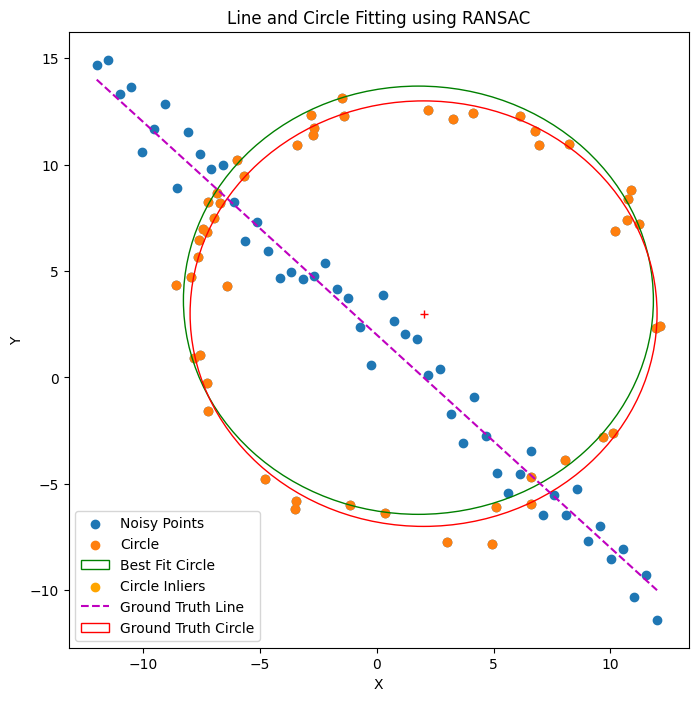

In [23]:

# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the noisy point set
ax.scatter(X[:, 0], X[:, 1], label='Noisy Points')
ax.scatter( X_circ[ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )

# Plot the best-fit line and its inliers
if best_line is not None:  # Check if the line was successfully estimated
    x_min, x_max = np.min(X_line[:, 0]), np.max(X_line[:, 0])
    y_min, y_max = best_line[2] / best_line[1] - best_line[0] * x_min / best_line[1], \
                   best_line[2] / best_line[1] - best_line[0] * x_max / best_line[1]
    ax.plot([x_min, x_max], [y_min, y_max], color='red', label='Best Fit Line')
    ax.scatter(X_line[line_inliers, 0], X_line[line_inliers, 1], color='blue', label='Line Inliers')

# Plot the best-fit circle and its inliers
if best_circle is not None:  # Check if the circle was successfully estimated
    x_circle, y_circle, r_circle = best_circle
    circle = Circle((x_circle, y_circle), r_circle, color='green', fill=False, label='Best Fit Circle')
    ax.add_patch(circle)
    ax.scatter(X_circ[circle_inliers, 0], X_circ[circle_inliers, 1], color='orange', label='Circle Inliers')

# Plot the sample of three points used for line and circle estimation
if best_line is not None and best_circle is not None:
    sample_points = np.vstack((X_line[np.random.choice(len(X_line), 3, replace=False)],
                               X_circ[np.random.choice(len(X_circ), 3, replace=False)]))
    ax.scatter(sample_points[:, 0], sample_points[:, 1], color='red', label='Sample Points')

# Add the ground truth line
ax.plot(x, m * x + b, color='m', linestyle='--', label='Ground Truth Line')

# Add the ground truth circle
circle_gt = Circle((x0_gt, y0_gt), r, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='red')

# Add legend and labels
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line and Circle Fitting using RANSAC')

plt.show()


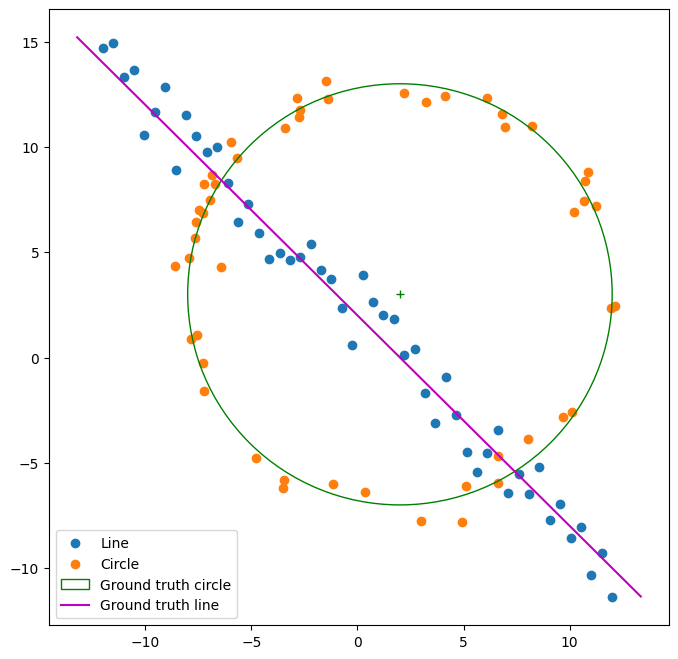

In [15]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# np . random. seed ( 0 )
N = 100
half_n = N//2

r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np.random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2

x = np .linspace(-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )

X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )

X = np . vstack ( ( X_circ , X_line ) ) # All points

fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8) )

ax.scatter( X_line [ : , 0 ] , X_line [ : , 1 ] , label= 'Line')
ax.scatter( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )

circle_gt = plt.Circle ( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= 'Ground truth circle' )
ax.add_patch ( circle_gt )
ax.plot( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g' )

x_min , x_max = ax.get_xlim ( )
x_ = np.array ( [ x_min , x_max ] )

y_ = m*x_ + b

plt . plot ( x_ , y_ , color= 'm' , label= 'Ground truth line' )
plt . legend ( )